In [3]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
from tqdm import tqdm
import seaborn as sns

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from graspy.plot import heatmap
from graspy.utils import get_multigraph_intersect_lcc, is_symmetric, symmetrize
from graspy.embed import JointRDPG
from graspy.cluster import GaussianCluster, KMeansCluster

from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.mgc.mgc import MGC

from utils import estimate_block_assignment, triu_no_diag, to_distance_mtx, identity, pvalue, block_permute, sort_graph

### Preprocessing

In [3]:
chem_male = pd.read_csv('../celegans_data/male_chem_A_full_undirected.csv', header=None).values
gap_male = pd.read_csv('../celegans_data/male_gap_A_full_undirected.csv', header=None).values

chem_cell = pd.read_csv('../celegans_data/male_chem_full_cells.csv', header=None)
gap_cell = pd.read_csv('../celegans_data/male_gap_full_cells.csv', header=None)

chem_cell = np.squeeze(chem_cell.values)
gap_cell = np.squeeze(gap_cell.values)

common_cell, chem_idx, gap_idx = np.intersect1d(chem_cell, gap_cell, return_indices=True)

chem_idx = np.sort(chem_idx)
gap_idx = np.sort(gap_idx)
chem_male = chem_male[np.ix_(chem_idx, chem_idx)]
gap_male = gap_male[np.ix_(gap_idx, gap_idx)]

chem_male = np.where(chem_male > 0, 1, 0).astype(float)
gap_male = np.where(gap_male > 0, 1, 0).astype(float)

chem_male.shape

(567, 567)

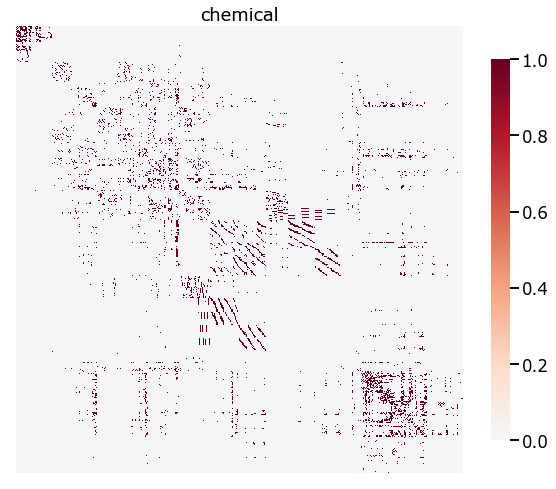

In [4]:
heatmap(chem_male, title='chemical')

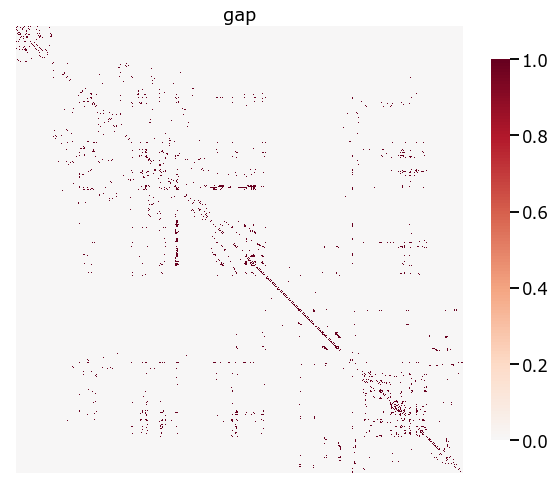

In [5]:
heatmap(gap_male, title='gap')

In [39]:
block_assignment = estimate_block_assignment(chem_male, gap_male, k=10, set_k=True, num_repeats=10)

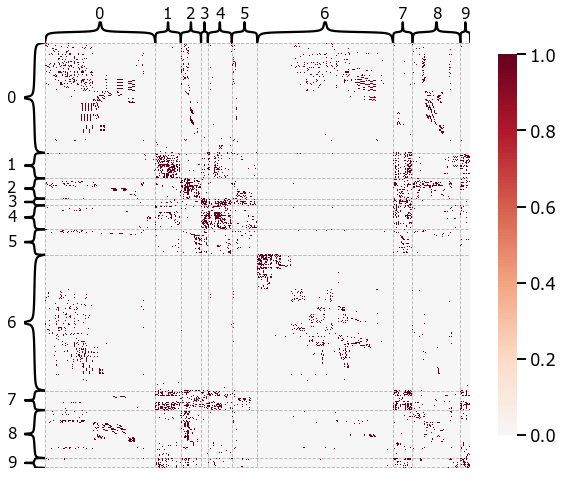

In [40]:
heatmap(chem_male, title='chemical', inner_hier_labels=block_assignment)

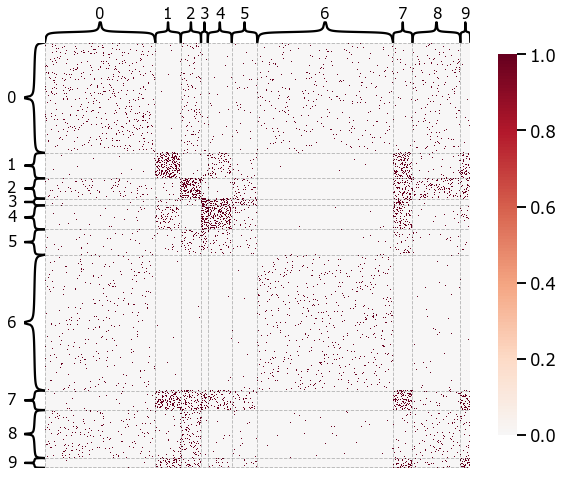

In [41]:
heatmap(block_permute(chem_male, block_assignment), inner_hier_labels=np.sort(block_assignment))

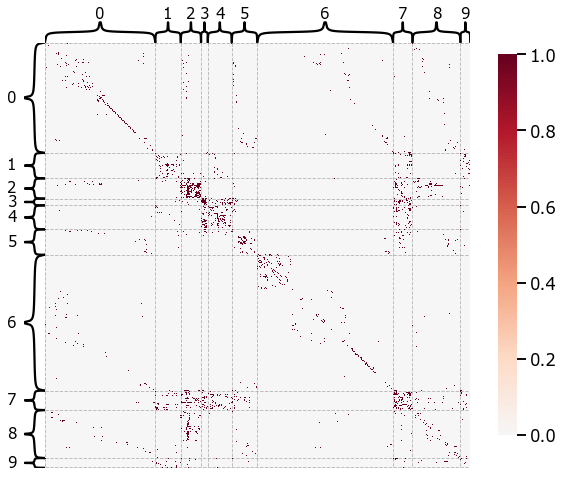

In [42]:
heatmap(gap_male, inner_hier_labels=block_assignment, title='gap')

### Fit model

In [6]:
mgc = MGC(compute_distance_matrix=identity)

In [21]:
pval = pvalue(A=chem_male, B=gap_male, indept_test=mgc, transform_func=to_distance_mtx, block_est_repeats=100,
             k=500, set_k=True)

  3%|▎         | 15/500 [00:47<25:17,  3.13s/it]

KeyboardInterrupt: 

In [8]:
test_stats_alt, _ = mgc.test_statistic(to_distance_mtx(chem_male), to_distance_mtx(gap_male))

In [9]:
block_assignment = estimate_block_assignment(chem_male, gap_male, k=550, set_k=True, num_repeats=1)

In [10]:
mgc.test_statistic(to_distance_mtx(sort_graph(chem_male, block_assignment)), 
                   to_distance_mtx(sort_graph(gap_male, block_assignment)))

(0.2561072737156404,
 {'local_correlation_matrix': array([[0.25610727, 0.25020761],
         [0.25322953, 0.24694708]]), 'optimal_scale': [1, 1]})

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
k_arr = np.logspace(start=1, stop=9, num=9, base=2, dtype=int)
reps = 10
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in tqdm(enumerate(k_arr)):
    for r in range(reps):
        block_assignment = estimate_block_assignment(chem_male, gap_male, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(chem_male, block_assignment)), 
                   to_distance_mtx(sort_graph(gap_male, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

3it [01:17, 23.31s/it]/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/jxiong/Documents/Projects/graph_independence_test/env/lib/python3.7/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
9it [29:19, 400.13s/it]


[]

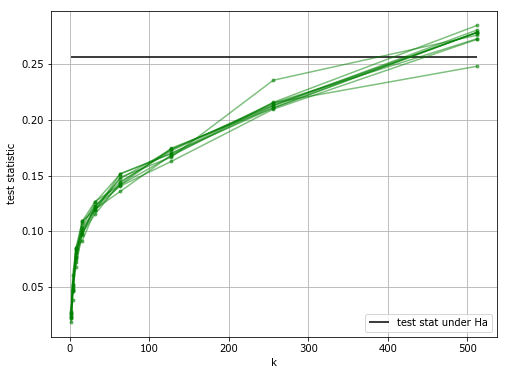

In [17]:
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

In [27]:
with open('../celegans_data/pvalue.pkl', 'rb') as f:
    pval = pickle.load(f)

In [28]:
pval

[(2, 0.0),
 (4, 0.0),
 (8, 0.0),
 (16, 0.0),
 (32, 0.0),
 (64, 0.0),
 (128, 0.0),
 (256, 0.0),
 (512, 1.0)]

### Weighted

In [5]:
chem_male = pd.read_csv('../data/celegans/male_chem_A_full_undirected.csv', header=None).values
gap_male = pd.read_csv('../data/celegans/male_gap_A_full_undirected.csv', header=None).values

chem_cell = pd.read_csv('../data/celegans/male_chem_full_cells.csv', header=None)
gap_cell = pd.read_csv('../data/celegans/male_gap_full_cells.csv', header=None)

chem_cell = np.squeeze(chem_cell.values)
gap_cell = np.squeeze(gap_cell.values)

common_cell, chem_idx, gap_idx = np.intersect1d(chem_cell, gap_cell, return_indices=True)

chem_idx = np.sort(chem_idx)
gap_idx = np.sort(gap_idx)
chem_male = chem_male[np.ix_(chem_idx, chem_idx)]
gap_male = gap_male[np.ix_(gap_idx, gap_idx)]

chem_male.shape

(567, 567)

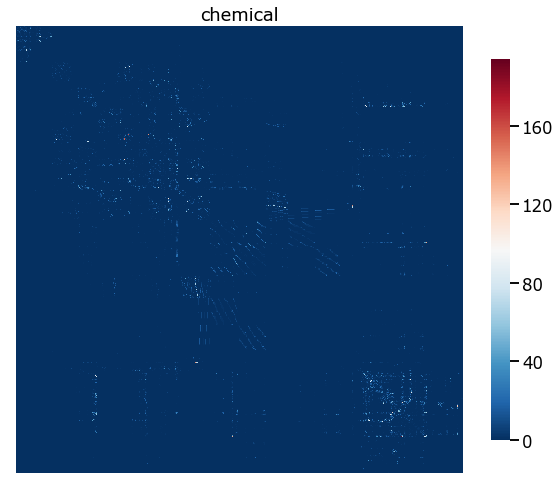

In [11]:
heatmap(chem_male, title='chemical', center=np.max(chem_male)/2)

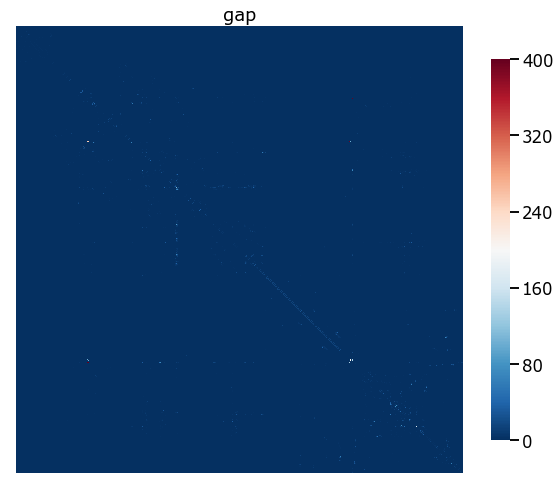

In [9]:
heatmap(gap_male, title='gap', center=np.max(gap_male)/2)

In [12]:
block_assignment = estimate_block_assignment(chem_male, gap_male, k=10, set_k=True, num_repeats=10)

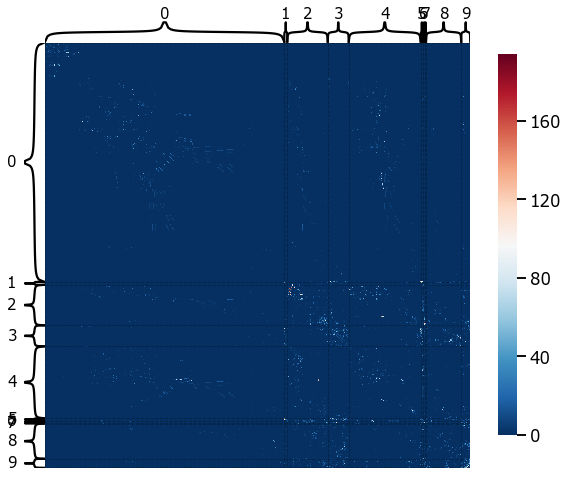

In [14]:
heatmap(chem_male, title='chemical', inner_hier_labels=block_assignment, center=np.max(chem_male)/2)

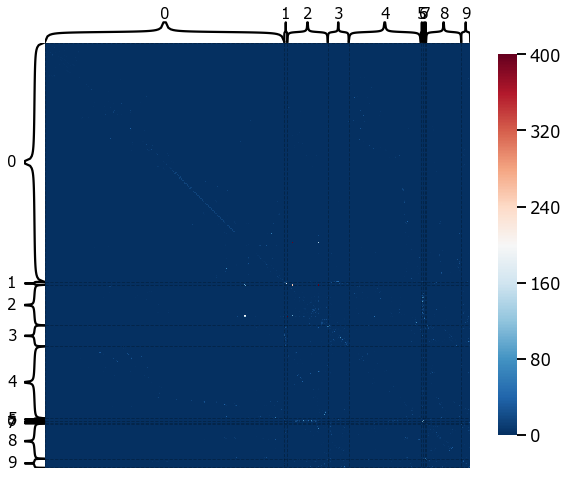

In [16]:
heatmap(gap_male, inner_hier_labels=block_assignment, title='gap', center=np.max(gap_male)/2)

In [17]:
mgc = MGC(compute_distance_matrix=identity)

In [21]:
test_stats_alt, lcm = mgc.test_statistic(to_distance_mtx(chem_male), to_distance_mtx(gap_male))

In [22]:
test_stats_alt

0.1046907177106898

In [24]:
lcm['optimal_scale']

[26, 19]

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
k_arr = np.logspace(start=1, stop=9, num=9, base=2, dtype=int)
reps = 100
test_stats_null_arr = np.zeros((k_arr.size, reps))
for i, k in tqdm(enumerate(k_arr)):
    for r in range(reps):
        block_assignment = estimate_block_assignment(chem_male, gap_male, k=k, set_k=True, num_repeats=50)
        test_stats_null, _ = mgc.test_statistic(to_distance_mtx(block_permute(chem_male, block_assignment)), 
                   to_distance_mtx(sort_graph(gap_male, block_assignment)))
        test_stats_null_arr[i, r] = test_stats_null

3it [11:34, 222.50s/it]

[]

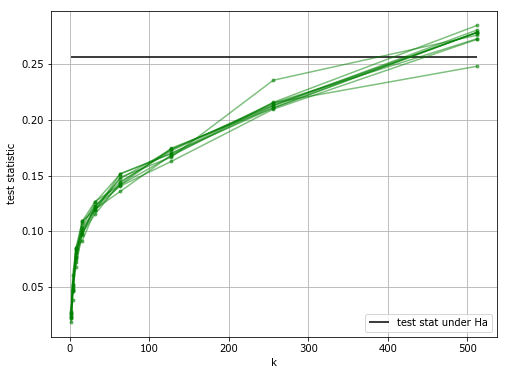

In [17]:
plt.figure(figsize=(8, 6))
for i in range(test_stats_null_arr.shape[1]):
    plt.plot(k_arr, test_stats_null_arr[:, i], color='g', marker='.', alpha=0.5)
plt.hlines(y=test_stats_alt, xmin=min(k_arr), xmax=max(k_arr), label='test stat under Ha')
plt.xlabel('k')
plt.ylabel('test statistic')
plt.legend(loc=4)
plt.grid()
plt.plot()

### Analysis on estimating block assignment
not updated for new intersection

In [59]:
random_state = None
num_rep = 500
rand = np.zeros(num_rep)
for i in tqdm(range(num_rep)):
    ba1 = estimate_block_assignment(chem_male, gap_male, k=10, svd='randomized', random_state=random_state)
    ba2 = estimate_block_assignment(chem_male, gap_male, k=10, svd='randomized', random_state=random_state)
    rand[i] = adjusted_rand_score(ba1, ba2)

100%|██████████| 500/500 [05:50<00:00,  1.37it/s]


Text(0, 0.5, 'Number of Occurences')

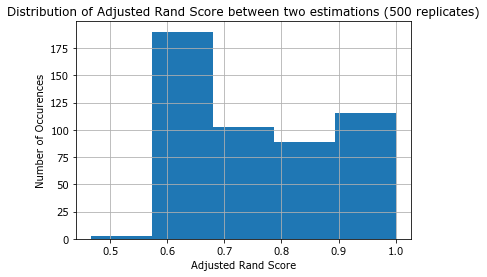

In [60]:
plt.hist(rand, bins=5)
plt.grid()
plt.title('Distribution of Adjusted Rand Score between two estimations (500 replicates)')
plt.xlabel('Adjusted Rand Score')
plt.ylabel('Number of Occurences')

In [61]:
rep = 500
num_blocks = np.zeros(rep)
for i in tqdm(range(rep)):
    block_assignment = estimate_block_assignment(chem_male, gap_male, k=10)
    num_blocks[i] = np.unique(block_assignment).size

100%|██████████| 500/500 [03:01<00:00,  2.74it/s]


In [62]:
np.arange(np.amin(num_blocks), np.amax(num_blocks)+2)

array([3., 4., 5., 6., 7., 8., 9.])

Text(0, 0.5, 'Number of Occurences')

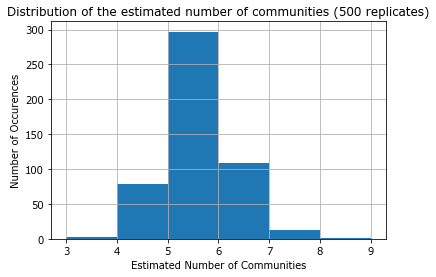

In [63]:
plt.hist(num_blocks, bins=np.arange(np.amin(num_blocks), np.amax(num_blocks)+2))
plt.grid()
plt.title('Distribution of the estimated number of communities (500 replicates)')
plt.xlabel('Estimated Number of Communities')
plt.ylabel('Number of Occurences')